#https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [ ]:
cols = ["bike_count", "hour", "temperature", "humidity", "wind", "visibility", "Dew_point_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("SeoulBikeData.csv").drop(["Date", "Holiday", "Seasons"], axis=1) # drop some columns (axis = 1 refers columns, axis = 0 refers rows)
df.columns = cols # name the columns
df.head()

,bike_count,hour,temperature,humidity,wind,visibility,Dew_point_temp,radiation,rain,snow,functional
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes


In [ ]:
df["functional"] = (df["functional"] == "Yes").astype(int) # redefine "yes" and "no" as "1" and "0"
df.head()

,bike_count,hour,temperature,humidity,wind,visibility,Dew_point_temp,radiation,rain,snow,functional
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,1
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,1
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,1
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,1
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,1


In [ ]:
df = df[df["hour"] == 12] # work with samples from 12 to 12 hours
df = df.drop("hour", axis=1) # eliminate the hour column as it will not be a feature used to predict the number of bikes
df.head()

,bike_count,temperature,humidity,wind,visibility,Dew_point_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


In [ ]:
df.columns[1:]

Index(['temperature', 'humidity', 'wind', 'visibility', 'Dew_point_temp',
       'radiation', 'rain', 'snow', 'functional'],
      dtype='object')

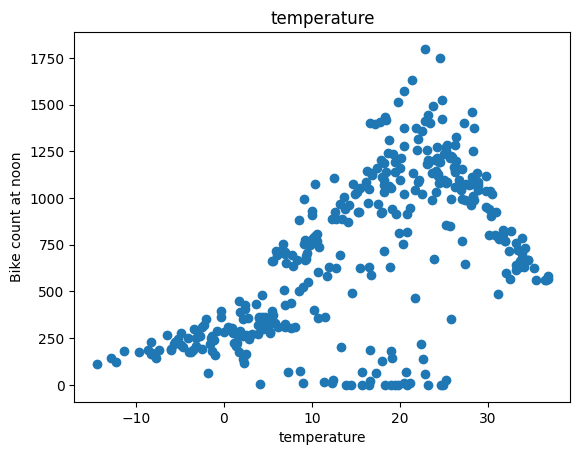

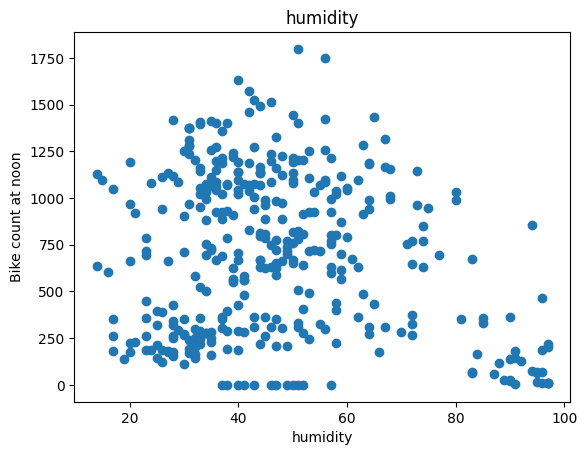

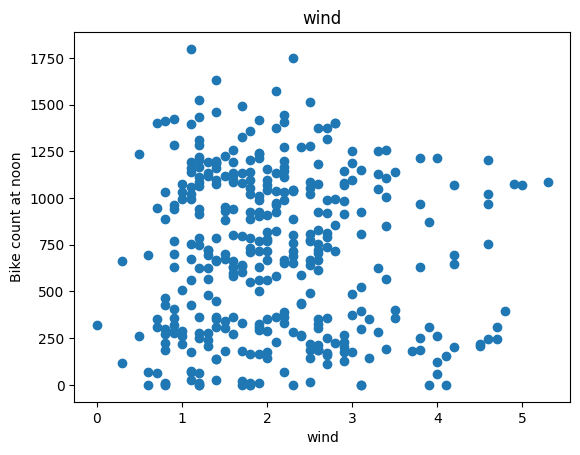

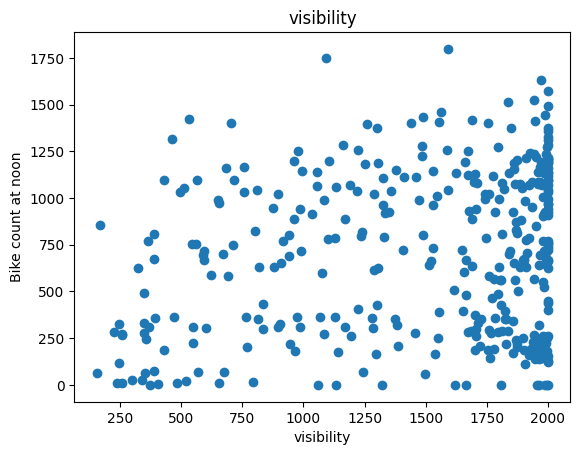

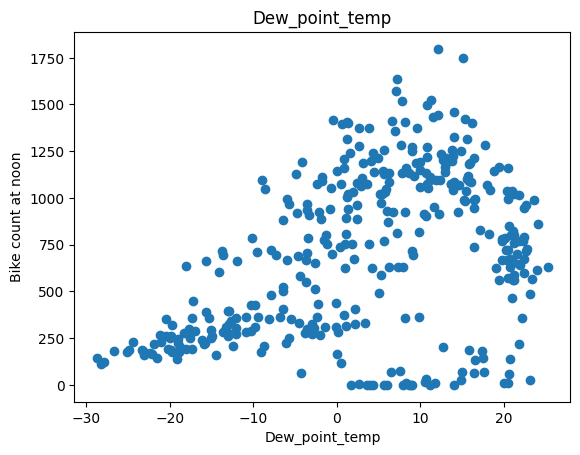

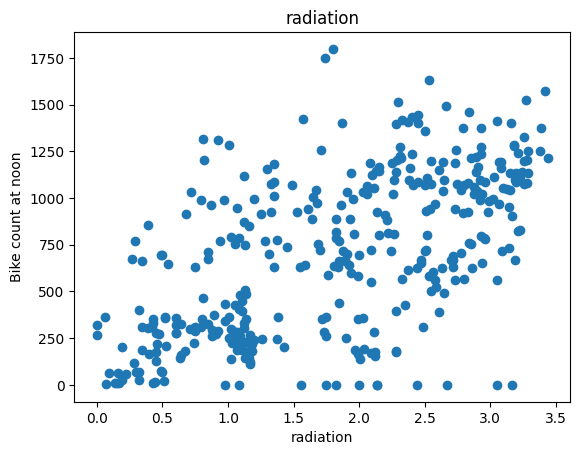

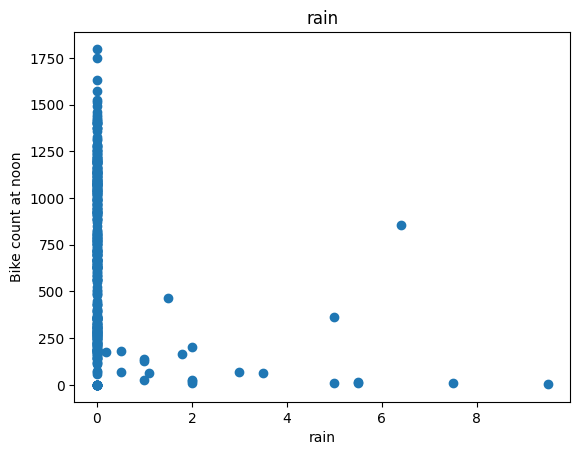

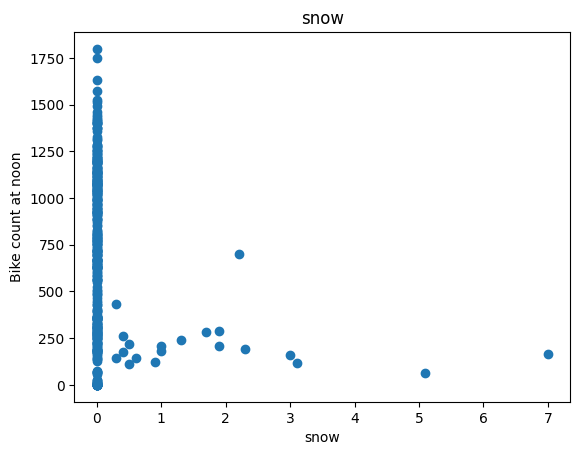

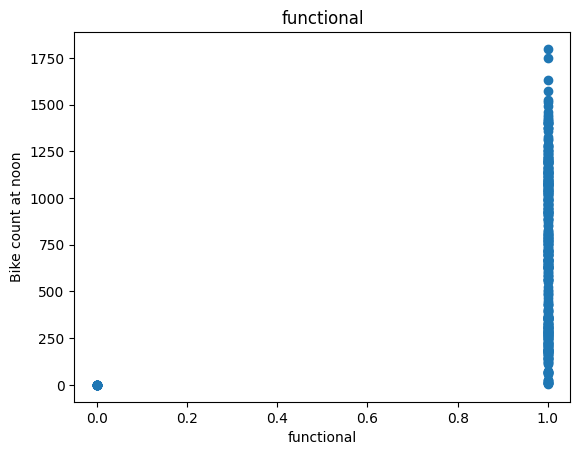

In [ ]:
for label in df.columns[1:]: # plot each column (feature) against the number of bikes to see which features have potential to help us to predict the number of bikes
  plt.scatter(df[label], df["bike_count"])
  plt.title(label)
  plt.ylabel("Bike count at noon")
  plt.xlabel(label)
  plt.show()


In [ ]:
df = df.drop(["wind", "visibility", "functional"], axis=1) # drop some columns that are not usefull for the prediction
df.head()

,bike_count,temperature,humidity,Dew_point_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


#Train, Validation, Test

In [ ]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))]) # split (np.split) the data randomly (df.sample) into train (60%), validation (20%) and test (20%) data

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
def get_xy(dataframe, y_label, x_labels=None): # None here means that the field is optional, we dont need to pass any x_labels
  dataframe = copy.deepcopy(dataframe) # copy dataframe
  if x_labels is None or len(x_labels) == 0: # if no x feature is provided or has len 0, assume all columns of the dataframe as features except the y column
    X = dataframe[[c for c in dataframe.columns if c != y_label]].values
  else: # if we provide one feature then transform it in an array (.values) and transform it in a 2D array (.reshape)
    if len(x_labels) == 1:
      X = dataframe[x_labels[0]].values.reshape(-1, 1)
    else: # if we provide more than one feature just transform into an array, as it is already 2D
      X = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1, 1) # transform the y column into array and reshape it into a 2D array
  data = np.hstack((X,y)) # stack the x features and the y column arrays horizontally

  return data, X, y

In [ ]:
_, X_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temperature"]) # use only the temperature feature
_, X_valid_temp, y_valid_temp = get_xy(valid, "bike_count", x_labels=["temperature"])
_, X_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temperature"])

#Regression

#Linear Regression

Finds the line (or hyperplane for more than one feature) that minimizes the sum of the residual, that is, the sum of the distances between the true values $y_i$  and the predicted values $\hat{y}_i$ (projection of the true values into the line)

So, the line of best feat minimizes the following

\begin{equation}
\sum_{i} \mid (y_i - \hat{y_i})^2 \mid
\end{equation}

In order to aplly Linear Regression 4 conditions need to be met

1. Linearity
2. Independence
3. Normality
4. Homoskedasticity

#
1. Linearity means that as x increases, the trend of y is to always increase (or decrease) linearly

2. Independence means that the features are independente from each other

3. Nomality means that the residual should be normally distributed

4. Homoskedasticity means that the variance of the residuals is constant

#
The line of best fit is as good predictor as R^2 (Coefficient of Determination) goes to 1

\begin{equation}
R^2 = 1 - \frac{\text{RSS}}{\text{TSS}} = 1 - \frac{\sum_{i} \mid (y_i - \hat{y_i})^2 \mid}{\sum_{i} \mid (y_i -  \bar{y}_i)^2 \mid}
\end{equation}
where RSS is the sum of squred residuals and TSS is the total sum of squares

In [ ]:
temp_reg = LinearRegression() # create model using the temperature feature
temp_reg.fit(X_train_temp, y_train_temp) # train model

LinearRegression()

In [ ]:
print(temp_reg.coef_, temp_reg.intercept_) # print "m" and "b" coefficients
print(temp_reg.score(X_train_temp, y_train_temp)) # print R^2

[[21.71916415]] [380.08491499]
0.3152611430041201


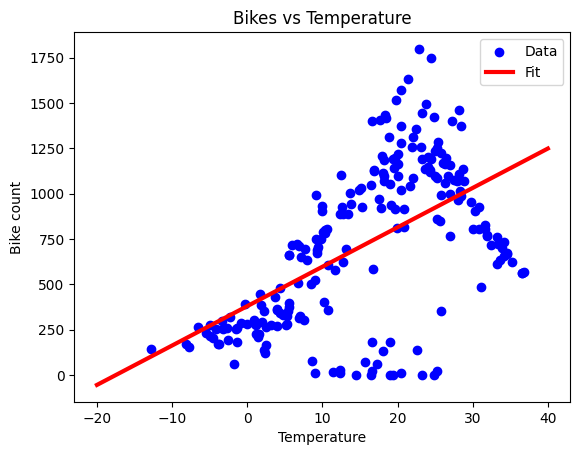

In [ ]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue") # training points
x=tf.linspace(-20, 40, 100) # x 1D array for best line
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3) # convert x linspace 1D array into 2D array to be used in the prediction
plt.legend()
plt.title("Bikes vs Temperature")
plt.xlabel("Temperature")
plt.ylabel("Bike count")
plt.show()

# Multiple Linear Regression

In [ ]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))]) # same but consider all x features
_, X_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, X_valid_all, y_valid_all = get_xy(valid, "bike_count", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
all_reg = LinearRegression() # create the model
all_reg.fit(X_train_all, y_train_all) # train the model

LinearRegression()

In [ ]:
print(all_reg.coef_, all_reg.intercept_) # print "m_1", ... "m_i" and "b" coefficients
print(all_reg.score(X_train_all, y_train_all)) # print R^2

[[-13.34344077 -11.38412743  31.04308234 155.52752375 -18.45921966
   -9.73767693]] [1057.90938114]
0.5180793835353975


# Regression with Neural Net

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [ ]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None) # normalize data, axis=None if only one feature
temp_normalizer.adapt(X_train_temp.reshape(-1)) # computes the mean and standard deviation of the train data

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
temp_nn_model =tf.keras.Sequential([ # create model: neural network without hidden layers and activation functions. This means the the response will be linear
    temp_normalizer,
    tf.keras.layers.Dense(units=1)
])

In [ ]:
temp_nn_model.compile( # compile model
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error') # since we are doing a linear regression use mean_squared_error residuals as the loss

In [ ]:
history = temp_nn_model.fit( # train model
    X_train_temp, y_train_temp,
    epochs=1000,
    verbose=0,
    validation_data=(X_valid_temp, y_valid_temp)
)

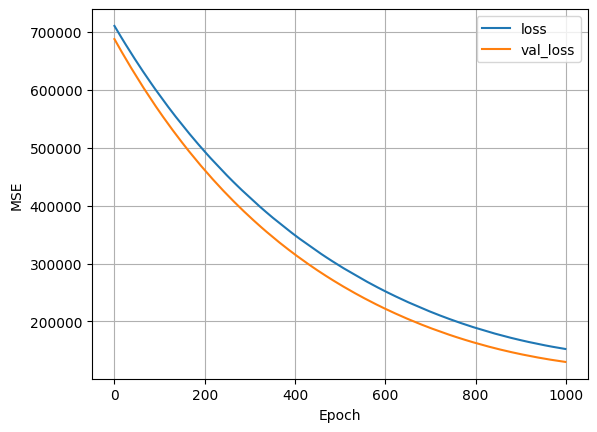

In [ ]:
plot_loss(history) # plot training data loss and validation data loss

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


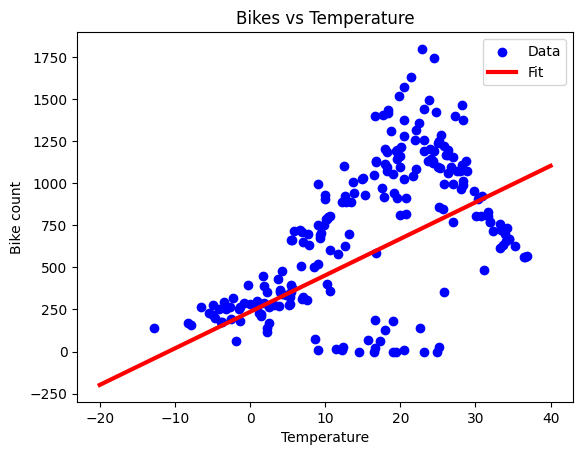

In [ ]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue") # plot test points
x=tf.linspace(-20, 40, 100) # x array for fit line
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3) # plot regression
plt.legend()
plt.title("Bikes vs Temperature")
plt.xlabel("Temperature")
plt.ylabel("Bike count")
plt.show()

#Neural Net

In [ ]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [ ]:
temp_nn_model =tf.keras.Sequential([ # create model
    temp_normalizer,
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="relu") #we cant have less than 0 bikes
])
temp_nn_model.compile( # compile model
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error')

In [ ]:
history = temp_nn_model.fit( # train model
    X_train_temp, y_train_temp,
    epochs=100,
    verbose=0,
    validation_data=(X_valid_temp, y_valid_temp)
)

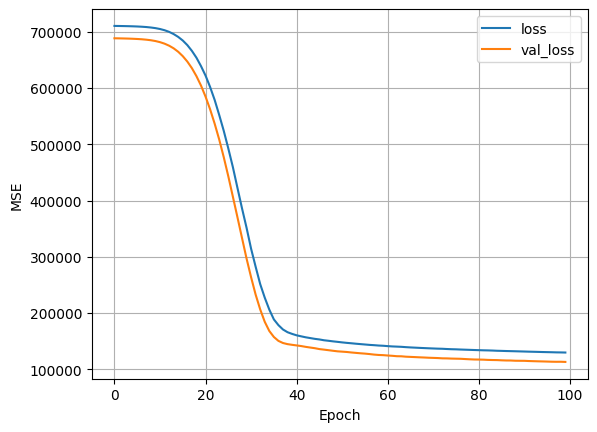

In [ ]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


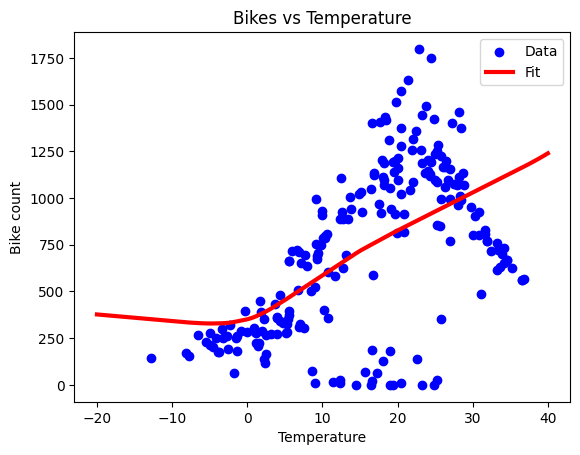

In [ ]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x=tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temperature")
plt.xlabel("Temperature")
plt.ylabel("Bike count")
plt.show()

In [ ]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(X_train_all)

all_nn_model =tf.keras.Sequential([ # create model using all features
    all_normalizer,
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dense(units=1)
])
all_nn_model.compile( # compile model
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error')

In [ ]:
history = all_nn_model.fit( # train model
    X_train_all, y_train_all,
    epochs=100,
    verbose=0,
    validation_data=(X_valid_all, y_valid_all)
)

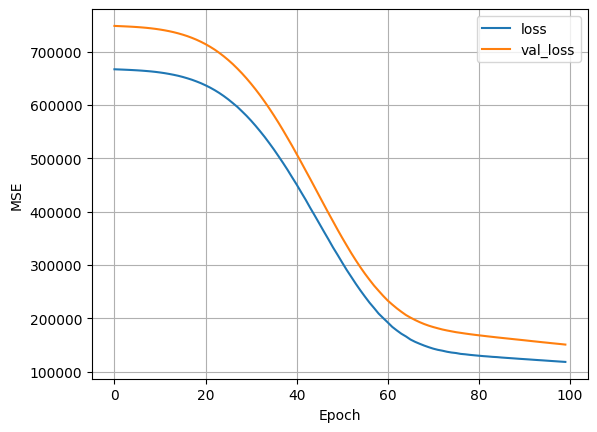

In [ ]:
plot_loss(history)

In [ ]:
y_pred_lr = all_reg.predict(X_test_all) # predictions from linear regression
y_pred_nn = all_nn_model.predict(X_test_all) # predictions from NN

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [ ]:
def MSE(y_true, y_pred): # mean squared error
  return np.mean((y_true - y_pred)**2)

In [ ]:
MSE(y_test_all, y_pred_lr) # mean squared error for linear regression

97885.3520534862

In [ ]:
MSE(y_test_all, y_pred_nn) # mean squared error for neural network

131073.396354898

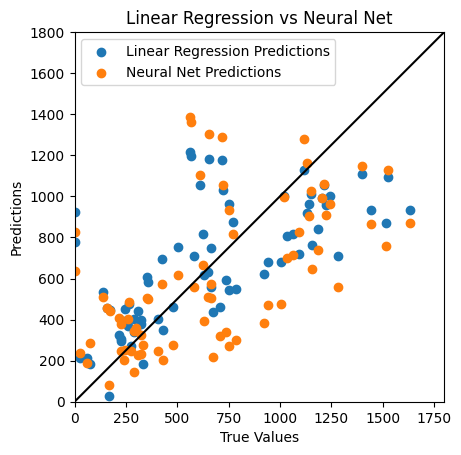

In [ ]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Linear Regression Predictions") # predicted values from linear regression vs true values
plt.scatter(y_test_all, y_pred_nn, label="Neural Net Predictions") # predicted values from neural networks vs true values
plt.title("Linear Regression vs Neural Net")
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, color="black") # line y = x to help visualize